## Info
Title: Image similarity estimation using a Siamese Network with triplet loss  
Author: Amin Nasiri 
Date created: 2025/07/25  
Last modified: 2025/08/13  
Description: Implementation of Siamese Networks with triplet loss for image similarity learning,  
featuring distributed training and comprehensive evaluation.  
Accelerator: GPU  


## Introduction

This example demonstrates how to train a Siamese Network using triplet loss for image similarity learning.  
Siamese networks are particularly useful for tasks where you need to learn similarity between images, 
such as face recognition, person re-identification, or product matching.  

### Key Features:
- Custom triplet loss implementation  
- Efficient tf.data pipeline for triplet generation 
- Distributed training across multiple GPUs 
- Progressive training (frozen backbone → fine-tuning)  
- Comprehensive evaluation with confusion matrices  

### What you'll learn:
- How to implement triplet loss for similarity learning 
- Creating efficient data pipelines for triplet training  
- Using transfer learning with ResNet50 for embeddings  
- Distributed training strategies 
- Evaluating similarity models  

### References:
- Image similarity (Keras example):  
  https://keras.io/examples/vision/siamese_network/

- Distributed training with Keras (TensorFlow tutorial)  
  https://www.tensorflow.org/tutorials/distribute/keras

- Distributed training guide (TensorFlow guide):  
  https://www.tensorflow.org/guide/distributed_training

## Setup and Imports

In [1]:
# Install required packages if not already installed
import os
import cv2
import random
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.saving import register_keras_serializable

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-09-08 16:11:26.878915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757362286.958844    4912 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757362286.981937    4912 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757362287.159297    4912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757362287.159317    4912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757362287.159318    4912 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Num GPUs Available:  2


## Configuration

We define all hyperparameters and settings in a configuration class.

In [2]:
class Config:
    BATCH_SIZE = 32
    TARGET_SHAPE = (224, 224)
    IMG_SHAPE = TARGET_SHAPE + (3,)
    INITIAL_EPOCHS = 1
    FINE_TUNE_EPOCHS = 1
    TRIPLETS_PER_EPOCH = 10000
    MARGIN = 0.5  # Triplet loss margin
    LEARNING_RATE = 0.001
    MIN_IMAGES_PER_CLASS = 20
    SPLIT_RATIO = (0.7, 0.2, 0.1)  # train, val, test
    STEPS_PER_EPOCH = TRIPLETS_PER_EPOCH // BATCH_SIZE
    SHUFFLE_BUFFER_SIZE = TRIPLETS_PER_EPOCH
    IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png')
    METRICS = ['accuracy', 'precision', 'recall']
    SIAMESE_SAVE_PATH = "./siamese_model.keras"  # Path to save the trained Siamese model
    EMBEDDING_SAVE_PATH = "./embedding_model.keras"  # Path to save the embedding model
    DATASET_PATH = "./sample_data"  # Path to dataset
    CACHE_DIR = "./Cache"  # Cache directory

    # Ensure cache directory exists
    os.makedirs(CACHE_DIR, exist_ok=True)

# Initialize configuration for easy access in the script.
config = Config()

## Sample Dataset Creation

For demonstration, we'll create a simple dataset. In practice, replace this with your actual dataset.   
Your dataset should be organized as: `path/class1/*.jpg, path/class2/*.jpg, etc.`


In [3]:
def create_sample_dataset(base_path):
    """Loads the oxford_flowers102 dataset into a tf.data.Dataset.
    Iterate over the dataset and save the images of samples as: `base_path/class_001/*.jpg, base_path/class_002/*.jpg, etc.`
    """
    print("Creating sample dataset...")
    os.makedirs(base_path, exist_ok=True)

    ds = tfds.load('oxford_flowers102', split='test', shuffle_files=True)

    for sample in ds.as_numpy_iterator():
        class_id = sample['label']
        class_path = os.path.join(base_path, f"class_{class_id:03d}")
        os.makedirs(class_path, exist_ok=True)

        img = sample['image']
        imgName = sample['file_name'].decode('utf-8')
        imgPath = os.path.join(class_path, imgName)
        cv2.imwrite(imgPath, img)

    print(f"Sample dataset created at {base_path}")
    return base_path

## A helper function to read images from a folder


In [4]:
# This function reads images from a specified folder and returns a list of randomly selected image paths.
def read_images_from_folder(folder_path, num_images, image_extensions):
    """Load and sample images from a folder and return their paths."""
    image_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(image_extensions)
        ]

    if len(image_files) < num_images:
        print(f"Not enough images in {folder_path}. Found {len(image_files)}, required {num_images}.")
        return

    random.shuffle(image_files)
    indices = np.linspace(0, len(image_files) - 1, num_images, dtype=int)
    selected_images = [image_files[i] for i in indices]

    return selected_images

## Dataset Management

In [5]:
# The `DatasetManager` class handles dataset directory structure and creates train/validation/test splits.
class DatasetManager:
    """Manages dataset directory structure and train/val/test splitting."""

    def __init__(self, dataset_path, min_images, split_ratio, image_extensions):
        self.dataset_path = dataset_path
        self.min_images = min_images
        self.split_ratio = split_ratio
        self.imageExtensions = image_extensions
        self.class_folders = self._collect_valid_folders()

    def _collect_valid_folders(self):
        """Collect folders with sufficient images."""
        valid_folders = {}

        if not os.path.exists(self.dataset_path):
            print("Dataset path not found. Creating sample dataset...")
            self.dataset_path = create_sample_dataset(self.dataset_path)

        for folder_name in os.listdir(self.dataset_path):
            folder_path = os.path.join(self.dataset_path, folder_name)
            if os.path.isdir(folder_path):
                imgs = read_images_from_folder(folder_path, self.min_images, self.imageExtensions)
                if imgs:
                    valid_folders[folder_path] = imgs

        print(f"Found {len(valid_folders)} valid classes")
        return valid_folders

    def get_splits(self):
        """Split folders into train/val/test sets."""
        idx = list(self.class_folders.keys())
        random.shuffle(idx)

        n_total = len(idx)
        n_train = int(self.split_ratio[0] * n_total)
        n_val = int(self.split_ratio[1] * n_total)

        train_dirs = idx[:n_train]
        val_dirs = idx[n_train:n_train + n_val]
        test_dirs = idx[n_train + n_val:]

        train_data = {folder: self.class_folders[folder] for folder in train_dirs}
        val_data = {folder: self.class_folders[folder] for folder in val_dirs}
        test_data = {folder: self.class_folders[folder] for folder in test_dirs}

        print(f"Dataset split - Train: {len(train_dirs)}, "
            f"Val: {len(val_dirs)}, Test: {len(test_dirs)}")

        return train_data, val_data, test_data

## Triplet Generation

The `TripletGenerator` creates triplet samples (anchor, positive, negative) for training.
For each triplet:
- **Anchor** and **Positive** come from the same class
- **Negative** comes from a different class

The goal is to minimize the distance between anchor-positive pairs while maximizing
the distance between anchor-negative pairs.

In [6]:
class TripletGenerator:
    """Generates triplet samples for training."""

    def __init__(self, class_images, mode='Train'):
        """Initialize triplet generator."""
        self.mode = mode
        self.class_images = class_images

        print(f"[{mode}] TripletGenerator: {len(self.class_images)} classes")


    def generate_triplets(self):
        """Generator yielding triplet paths."""
        class_names = list(self.class_images.keys())

        while True:
            # Select anchor class and different negative class
            anchor_class, negative_class = random.sample(class_names, 2)

            # Select images
            anchor_img, positive_img = np.random.choice(
                self.class_images[anchor_class], 2, replace=False
            )
            negative_img = random.choice(self.class_images[negative_class])

            yield anchor_img, positive_img, negative_img

## Image Processing

In [7]:
# The `ImageProcessor` handles loading, decoding, and preprocessing of images.
class ImageProcessor:
    """Handles image loading and preprocessing."""

    def __init__(self, target_shape):
        self.target_shape = target_shape

    def decode_and_resize(self, image_path):
        """Load and preprocess a single image."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, self.target_shape)
        image.set_shape(self.target_shape + (3,))
        return image

    def process_triplet(self, anchor_path, positive_path, negative_path):
        """Process a triplet of image paths."""
        anchor = self.decode_and_resize(anchor_path)
        positive = self.decode_and_resize(positive_path)
        negative = self.decode_and_resize(negative_path)

        return (anchor, positive, negative), 0.0  # Dummy label

## tf.data Pipeline

In [8]:
# Create an optimized tf.data pipeline for efficient triplet loading and preprocessing.
def create_tf_dataset(class_images, config, mode='train'):
    """Create optimized tf.data.Dataset for triplet training."""

    generator = TripletGenerator(class_images, mode.title())
    processor = ImageProcessor(config.TARGET_SHAPE)

    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator.generate_triplets,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )

    # Apply processing pipeline
    dataset = dataset.map(processor.process_triplet, num_parallel_calls=1)

    if mode == 'train':
        dataset = dataset.shuffle(config.SHUFFLE_BUFFER_SIZE)

    else:
        dataset = dataset.take(config.TRIPLETS_PER_EPOCH)
        dataset = dataset.cache(f'{config.CACHE_DIR}/cache_{mode.title()}')

    dataset = dataset.batch(config.BATCH_SIZE, drop_remainder=(mode == 'train'))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

## Triplet Loss Implementation

Custom triplet margin loss encourages the network to place anchor closer to positive
than to negative by at least a margin.

**Loss = max(distance(anchor, positive) - distance(anchor, negative) + margin, 0)**

In [9]:
@register_keras_serializable()
class TripletMarginLoss(tf.keras.losses.Loss):
    """Custom triplet margin loss implementation."""

    def __init__(self, margin=0.5, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        """
        Args:
            y_true: Unused (dummy labels)
            y_pred: Tensor of shape (batch_size, 2) containing [ap_distance, an_distance]
        """
        ap_distance = y_pred[:, 0]  # Anchor-positive distance
        an_distance = y_pred[:, 1]  # Anchor-negative distance

        # Triplet loss: max(ap_distance - an_distance + margin, 0)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({"margin": self.margin})
        return config

## Distance Layer

Custom layer to compute pairwise distances for triplet loss.

In [10]:
class DistanceLayer(tf.keras.layers.Layer):
    """Computes L2 distances between anchor-positive and anchor-negative pairs."""

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.stack([ap_distance, an_distance], axis=1)

## Model Architecture

We create a Siamese network using ResNet50 as the backbone encoder.
The network produces normalized embeddings that are compared using L2 distance.

### Why normalize embeddings?
- Projects embeddings onto unit hypersphere
- Makes Euclidean distance equivalent to cosine similarity
- Improves training stability and convergence

In [11]:
def create_siamese_model(config, fine_tuning=False):
    """Create Siamese network with ResNet50 backbone."""

    # ResNet50 backbone
    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",
        input_shape=config.IMG_SHAPE,
        include_top=False
    )

    # Configure trainable layers
    if fine_tuning:
        base_model.trainable = True
        # Freeze early layers, unfreeze last layers
        for layer in base_model.layers[:-20]:
            layer.trainable = False
    else:
        base_model.trainable = False

    # Build embedding network
    inputs = tf.keras.Input(shape=config.IMG_SHAPE)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128)(x)
    embeddings = tf.keras.layers.UnitNormalization(axis=1)(x)

    embedding_model = tf.keras.Model(inputs, embeddings, name='embedding')

    # Build Siamese network
    anchor_input = tf.keras.Input(shape=config.IMG_SHAPE, name='anchor')
    positive_input = tf.keras.Input(shape=config.IMG_SHAPE, name='positive')
    negative_input = tf.keras.Input(shape=config.IMG_SHAPE, name='negative')

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    distances = DistanceLayer()(anchor_embedding, positive_embedding, negative_embedding)

    siamese_model = tf.keras.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=distances,
        name='siamese_network'
    )

    return siamese_model

## Visualization Functions

Let's create some helper functions to visualize our data and results.

In [12]:
def visualize_triplets(dataset, num_examples=3):
    """Visualize sample triplets from the dataset."""
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))

    for batch in dataset.take(1):
        inputs, _ = batch
        anchor_batch, positive_batch, negative_batch = inputs

        for i in range(min(num_examples, len(anchor_batch))):
            titles = ['Anchor', 'Positive', 'Negative']
            images = [anchor_batch[i], positive_batch[i], negative_batch[i]]

            for j, (img, title) in enumerate(zip(images, titles)):
                ax = axes[i, j] if num_examples > 1 else axes[j]
                ax.imshow(img.numpy())
                ax.set_title(f'{title}' if i == 0 else '')
                ax.axis('off')
        break

    plt.tight_layout()
    plt.show()

In [13]:
def plot_training_history(history1, history2=None, config=None):
    """Plot training and validation loss."""
    plt.figure(figsize=(12, 4))

    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')

    if config and history2:
        plt.axvline(x=config.INITIAL_EPOCHS, color='orange',
                   linestyle='--', label='Start Fine-tuning')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Training Pipeline

We use a two-phase training approach:
1. **Phase 1**: Train with frozen ResNet50 backbone
2. **Phase 2**: Fine-tune by unfreezing some layers

This progressive approach helps stabilize training and often leads to better results.

In [14]:
def train_model():
    """Main training pipeline."""
    print("Starting training pipeline...")

    # Setup distributed strategy
    strategy = tf.distribute.MirroredStrategy()
    print(f"Training on {strategy.num_replicas_in_sync} devices")

    # Prepare dataset
    dataset_manager = DatasetManager(config.DATASET_PATH, config.MIN_IMAGES_PER_CLASS,
                                     config.SPLIT_RATIO, config.IMAGE_EXTENSIONS)
    train_folders, val_folders, test_folders = dataset_manager.get_splits()

    # Create datasets
    train_dataset = create_tf_dataset(train_folders, config, 'train')
    val_dataset = create_tf_dataset(val_folders, config, 'val')


    # Visualize sample triplets
    print("Sample triplets from training data:")
    visualize_triplets(train_dataset)

    # Build and compile model
    with strategy.scope():
        siamese_model = create_siamese_model(config)

        siamese_model.compile(
            optimizer=tf.keras.optimizers.Adam(config.LEARNING_RATE),
            loss=TripletMarginLoss(margin=config.MARGIN)
        )

    print("\nSiamese Network Architecture:")
    siamese_model.summary()

    # Setup callbacks
    checkpoint_cb = ModelCheckpoint(
        filepath=config.SIAMESE_SAVE_PATH,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Phase 1: Train with frozen backbone
    print(f"\n=== Phase 1: Frozen backbone training ({config.INITIAL_EPOCHS} epochs) ===")
    history1 = siamese_model.fit(
        train_dataset,
        steps_per_epoch=config.STEPS_PER_EPOCH,
        validation_data=val_dataset,
        epochs=config.INITIAL_EPOCHS,
        callbacks=[checkpoint_cb]
    )

    # Phase 2: Fine-tuning
    print(f"\n=== Phase 2: Fine-tuning ({config.FINE_TUNE_EPOCHS} epochs) ===")

    with strategy.scope():
        siamese_model_ft = create_siamese_model(config, fine_tuning=True)
        siamese_model_ft.load_weights(config.SIAMESE_SAVE_PATH)

        # Use lower learning rate for fine-tuning
        siamese_model_ft.compile(
            optimizer=tf.keras.optimizers.Adam(config.LEARNING_RATE * 0.1),
            loss=TripletMarginLoss(margin=config.MARGIN)
        )

    history2 = siamese_model_ft.fit(
        train_dataset,
        validation_data=val_dataset,
        steps_per_epoch=config.STEPS_PER_EPOCH,
        epochs=config.INITIAL_EPOCHS + config.FINE_TUNE_EPOCHS,
        initial_epoch=config.INITIAL_EPOCHS,
        callbacks=[checkpoint_cb]
    )

    # Plot training history
    plot_training_history(history1, history2, config)

    print("\nTraining completed successfully!")

    return siamese_model_ft, test_folders

## Extract embedding model and save it
We extract the embedding model from the Siamese network and save it for later use.  
This allows us to use the trained embeddings for inference or evaluation without needing the full Siamese model.

In [15]:
def extract_embedding_model(siamese_model, save_path):
    """Extract the embedding model from the Siamese network."""

    try:
        embedding_model = siamese_model.get_layer('embedding')

        # Save the embedding model to a file
        embedding_model.save(save_path)
        print(f"Embedding model saved as {os.path.basename(save_path)}")

        return embedding_model

    except ValueError:
        print("Embedding model not found in the Siamese network!")
        return

## A helper function to display results as a heatmap using Seaborn.
This function visualizes the confusion matrix results in a heatmap format.  
It provides a clear view of model performance across different classes.

In [16]:
def display_heatmap(results, x_vals, y_vals, x_label, y_label, title, **kwargs):
    """Display results as a heatmap."""
    sns.heatmap(results, xticklabels=x_vals, yticklabels=y_vals, annot=True, **kwargs)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

## Model Evaluation

Evaluate the trained model using a confusion matrix approach.

In [17]:
def evaluate_model(embedding_model, test_folders, config):
    """Evaluate the trained model on test set."""

    print("\n=== Model Evaluation ===")

    def load_images(imgs_path):
        """Load and preprocess images from a folder."""

        images = []
        for img_path in imgs_path:
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img = tf.cast(img, tf.float32) / 255.0
            img = tf.image.resize(img, config.TARGET_SHAPE)
            images.append(img)

        images = tf.stack(images)
        return tf.keras.applications.resnet.preprocess_input(images)

    # Load test data and extract embeddings
    indicators = []
    test_samples = []

    print("Extracting embeddings from test set...")
    for imgs_path in test_folders.values():
        images = load_images(imgs_path)
        embeddings = embedding_model(images)
        indicators.append(embeddings[0])  # First as indicator
        test_samples.append(embeddings[1:])  # Rest as test samples

    if not indicators:
        print("No valid test data found!")
        return

    indicators = tf.stack(indicators)
    test_samples = tf.stack(test_samples)

    print(f"Test data shape - Indicators: {indicators.shape}, Test samples: {test_samples.shape}")

    # Compute confusion matrix based on distance comparisons
    confusion_matrix = []
    num_classes = len(indicators)

    for i in range(num_classes):
        indicator = indicators[i]
        pos_samples = test_samples[i]

        # Compute anchor-positive distances
        ap_distances = tf.reduce_sum(tf.square(indicator - pos_samples), axis=-1)

        confusion_row = [0] * num_classes

        for j in range(num_classes):
            if i == j:
                continue

            neg_samples = test_samples[j]
            # Compute anchor-negative distances
            an_distances = tf.reduce_sum(tf.square(indicator - neg_samples), axis=-1)

            # Compare distances - we want ap_distance < an_distance for all pairs
            # Reshape for broadcasting
            ap_distances_reshaped = tf.reshape(ap_distances, (-1, 1))

            # Broadcast comparison
            comparisons = ap_distances_reshaped < an_distances

            # Count correct predictions
            correct_count = tf.reduce_sum(tf.cast(comparisons, tf.int32)).numpy()

            # Count total comparisons
            total_comparisons = tf.size(ap_distances) * tf.size(an_distances)

            # Count incorrect predictions
            incorrect_count = total_comparisons.numpy() - correct_count

            # Update confusion matrix row
            confusion_row[i] += correct_count
            confusion_row[j] += incorrect_count

        confusion_matrix.append(confusion_row)

    confusion_matrix = np.array(confusion_matrix)

    # Visualize results
    plt.figure(figsize=(10, 8))
    class_names = [f'ID_{i}' for i in range(num_classes)]
    display_heatmap(confusion_matrix, class_names, class_names, 'Predicted', 'Actual', 'Confusion Matrix', fmt='d', cmap='Blues')

    # Compute metrics
    metrics = []
    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp
        tn = confusion_matrix.sum() - tp - fp - fn

        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        metrics.append([accuracy, precision, recall])

    metrics = np.array(metrics)
    avg_metrics = metrics.mean(axis=0)

    print(f"\nAverage Metrics:")
    print(f"Accuracy: {avg_metrics[0]:.3f}")
    print(f"Precision: {avg_metrics[1]:.3f}")
    print(f"Recall: {avg_metrics[2]:.3f}")

    # Prepare metrics for heatmap
    metrics = np.vstack([metrics, avg_metrics])

    # Add label for the average metrics row
    class_names.append('Average per class')

    display_heatmap(metrics * 100, config.METRICS, class_names, 'Metrics', 'Classes', 'Per-Class Performance Metrics',
                    fmt='.2f', cmap='Greens', linewidths=0.5, cbar_kws={'label': 'Score (%)'})

    print("\nEvaluation completed successfully!")

## Clear TensorFlow cache files
This function clears TensorFlow cache files in the specified directory.  
This is useful to free up space or reset the cache for a fresh start.

In [18]:
def clear_tf_cache(cache_dir):
    """Clear TensorFlow cache files in the specified directory."""
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        print(f"Cache directory '{cache_dir}' removed.")
    else:
        print(f"Cache directory '{cache_dir}' does not exist. No files to remove.")

## Complete Example

Let's put it all together and run the complete training and evaluation pipeline.

Starting training pipeline...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1757362343.570503    4912 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46719 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:29:00.0, compute capability: 8.6
I0000 00:00:1757362343.572376    4912 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46262 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


Training on 2 devices
Found 102 valid classes
Dataset split - Train: 71, Val: 20, Test: 11
[Train] TripletGenerator: 71 classes
[Val] TripletGenerator: 20 classes
Sample triplets from training data:


2025-09-08 16:12:36.146221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3047 of 10000
2025-09-08 16:12:56.150241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8818 of 10000
2025-09-08 16:13:00.497839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


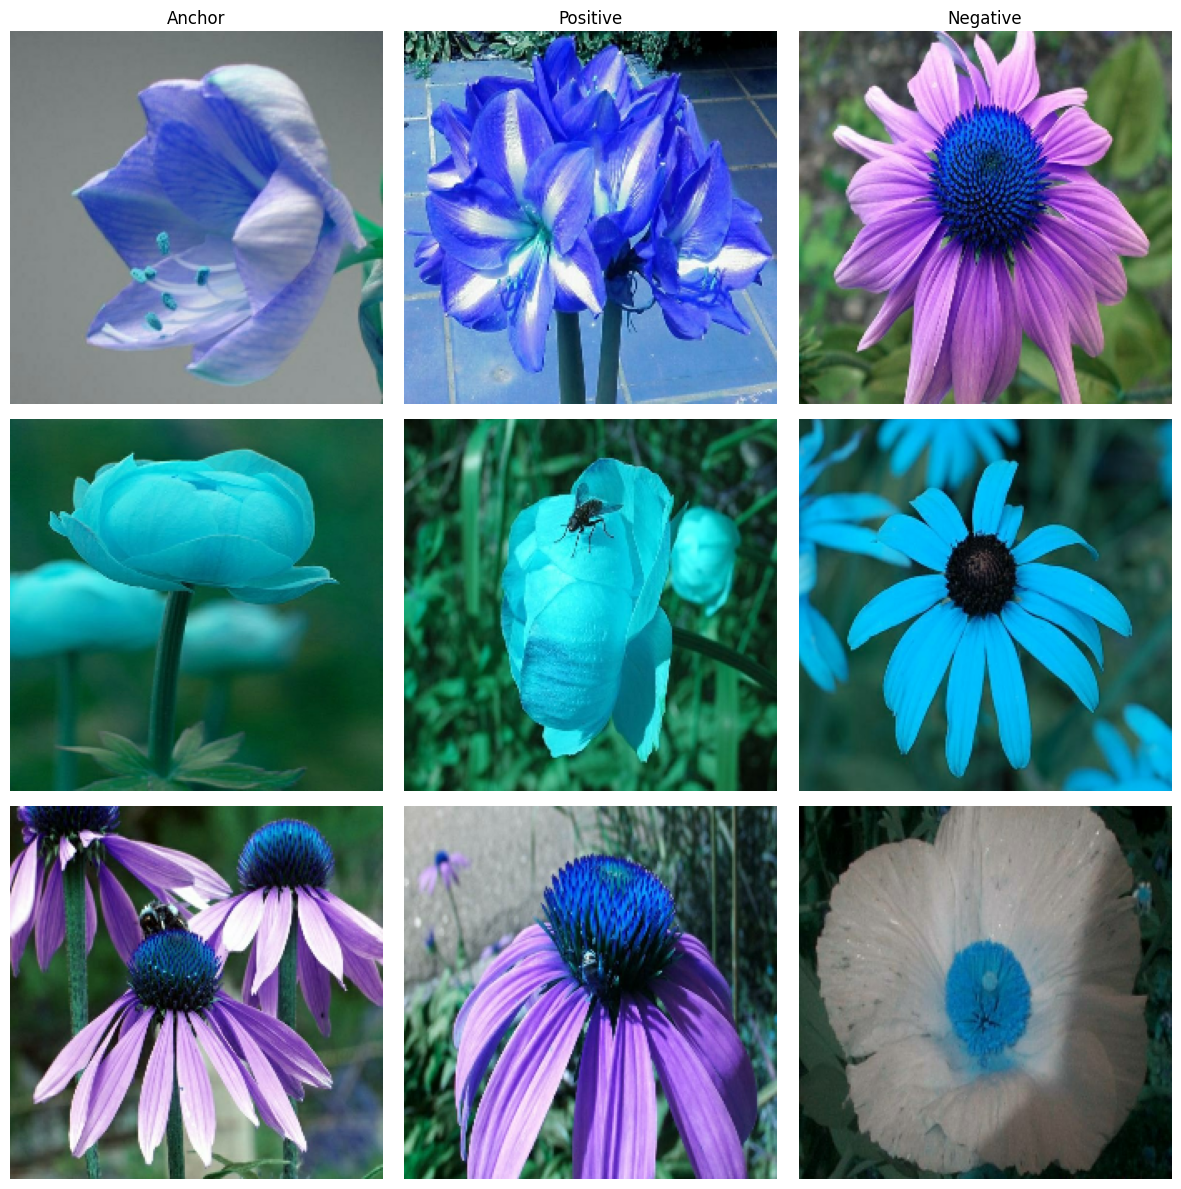


Siamese Network Architecture:


Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128)       │ 24,803,072 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer      │ (None, 2)         │          0 │ embedding[0][0],  │
│ (DistanceLayer)     │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,803,072 (94.62 MB)

 Trainable params: 1,214,336 (4.63 MB)

 Non-trainable params: 23,588,736 (89.98 MB)


=== Phase 1: Frozen backbone training (1 epochs) ===


2025-09-08 16:13:13.622387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3728 of 10000
2025-09-08 16:13:23.623019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7415 of 10000


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-09-08 16:13:30.489078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-09-08 16:13:57.396183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3078 of 10000
2025-09-08 16:14:07.397753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 6111 of 10000
2025-09-08 16:14:17.398720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9115 of 10000
2025-09-08 16:14:20.352600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1757362460.598953    5306 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757362460.598961    5304 cuda_dnn.cc:529] Loaded cuDNN version 90300


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.6877INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-09-08 16:15:21.240467: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-09-08 16:15:21.240509: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-09-08 16:15:21.240653: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 1: val_loss improved from inf to 0.85746, saving model to ./siamese_model.keras


2025-09-08 16:15:22.029499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14286518056167256866
2025-09-08 16:15:22.029528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18235990040213751639
2025-09-08 16:15:22.029532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13030906888632054289
2025-09-08 16:15:22.029553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17428057987391452351
2025-09-08 16:15:22.029564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16733987712909043570
2025-09-08 16:15:22.029580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7459347944040238330
2025-09-08 16:15:22.029582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous rec

312/312 ━━━━━━━━━━━━━━━━━━━━ 109s 188ms/step - loss: 0.6875 - val_loss: 0.8575

=== Phase 2: Fine-tuning (1 epochs) ===


2025-09-08 16:15:37.046731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 2882 of 10000
2025-09-08 16:15:47.047546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 5900 of 10000
2025-09-08 16:15:57.048122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8768 of 10000
2025-09-08 16:16:01.820955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Epoch 2/2
INFO:tensorflow:Collective all_reduce tensors: 32 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-09-08 16:16:34.028171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 2507 of 10000
2025-09-08 16:16:44.031242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 5168 of 10000
2025-09-08 16:17:01.376734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.6612
Epoch 2: val_loss improved from 0.85746 to 0.73893, saving model to ./siamese_model.keras


2025-09-08 16:18:03.269974: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-09-08 16:18:03.307050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14286518056167256866
2025-09-08 16:18:03.307074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18235990040213751639
2025-09-08 16:18:03.307081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9441782303917762737
2025-09-08 16:18:03.307094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13030906888632054289
2025-09-08 16:18:03.307100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17428057987391452351
2025-09-08 16:18:03.307106: I 

312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 195ms/step - loss: 0.6608 - val_loss: 0.7389


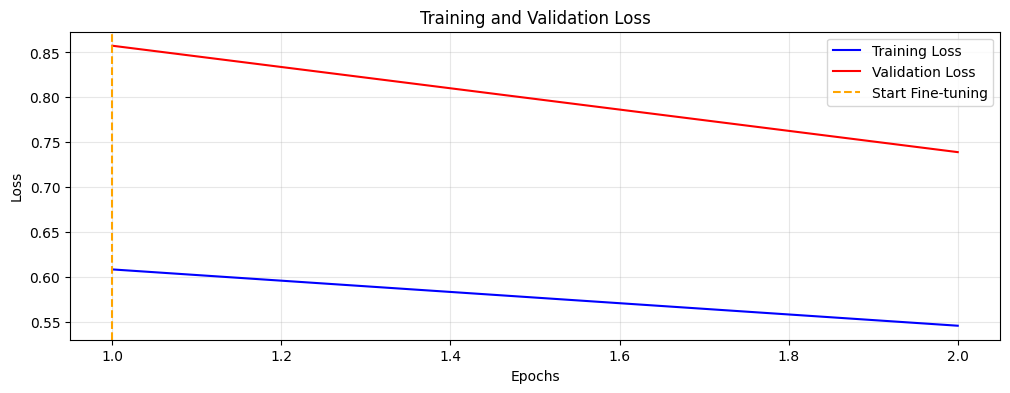


Training completed successfully!
Embedding model saved as embedding_model.keras

=== Model Evaluation ===
Extracting embeddings from test set...
Test data shape - Indicators: (11, 128), Test samples: (11, 19, 128)


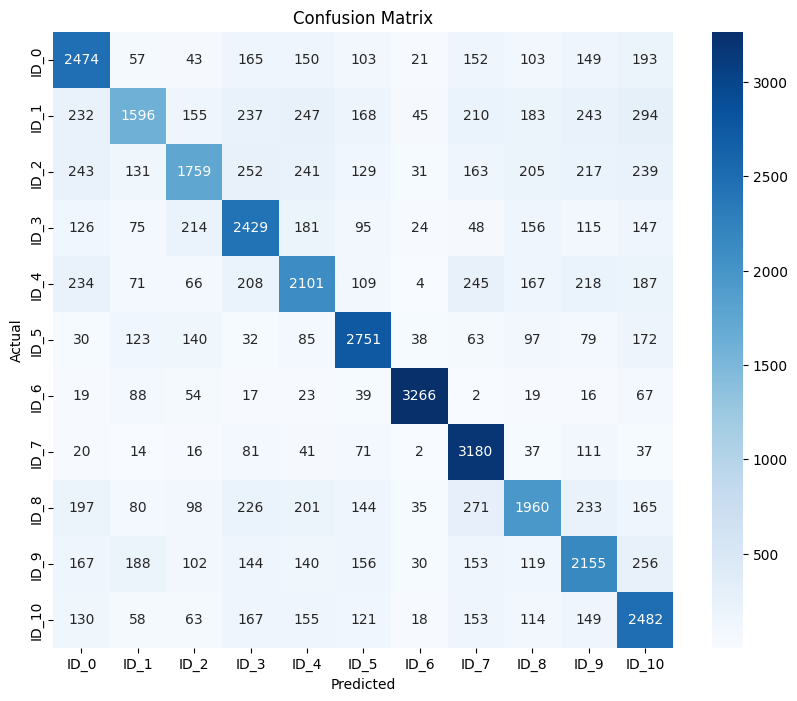


Average Metrics:
Accuracy: 0.938
Precision: 0.659
Recall: 0.659


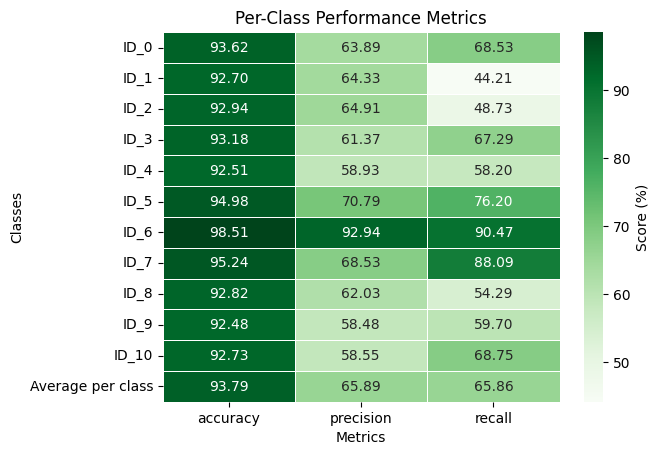


Evaluation completed successfully!
Cache directory './Cache' removed.


In [19]:
try:
    # Train the model
    trained_model, test_folders = train_model()

    # For evaluation, we need test data and the trained embedding model
    trained_embedding_model = extract_embedding_model(trained_model, config.EMBEDDING_SAVE_PATH)

    if test_folders and trained_embedding_model:
        evaluate_model(trained_embedding_model, test_folders, config)
        clear_tf_cache(config.CACHE_DIR)

    elif trained_model:
         print("\nTraining completed, but no test data or embedding model available for evaluation.")

    else:
        print("No trained model available for evaluation.")

except Exception as e:
    clear_tf_cache(config.CACHE_DIR)
    print(f"An error occurred during training or evaluation: {e}")
    print("Please check your dataset and configuration settings.")